In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import networkx as nx
import warnings
%pip install torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
nltk.download('punkt')
nltk.download('stopwords')



Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to load and preprocess the dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with {len(df)} poems")
    
    # Cheecking for missing value
    if df['poem_text'].isna().sum() > 0:
        print(f"Warning: {df['poem_text'].isna().sum()} poems have NaN text. Removing them.")
        df = df.dropna(subset=['poem_text'])
    
    # Preprocess text
    df['processed_text'] = df['poem_text'].apply(preprocess_text)
    
    if 'form' in df.columns:
        target = 'form'
    elif 'theme_tags' in df.columns:
        df['primary_theme'] = df['theme_tags'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) and ',' in x else x)
        target = 'primary_theme'
    
    # Keep only classes with at least 5 samples
    class_counts = df[target].value_counts()
    valid_classes = class_counts[class_counts >= 5].index
    df = df[df[target].isin(valid_classes)]
    
    print(f"After preprocessing: {len(df)} poems and {len(valid_classes)} classes")
    print(f"Target column: {target}")
    print(f"Top 5 classes: {class_counts[:5].to_dict()}")
    
    # Encoding the  target variable
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['target_id'] = le.fit_transform(df[target])
    
    return df, le, target



In [3]:
# Function to split dataset
def split_data(df, test_size=0.2, val_size=0.1):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        df['processed_text'], df['target_id'], 
        test_size=test_size, random_state=42, stratify=df['target_id']
    )
    
    # Further split train into train and validation
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_ratio, random_state=42, stratify=y_train_val
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test



In [ ]:
# TRADITIONAL MACHINE LEARNING

# 1. Naive Bayes
def train_naive_bayes(X_train, y_train, X_test, y_test):
    # Create TF-IDF features
    tfidf = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Train Naive Bayes
    nb = MultinomialNB()
    nb.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = nb.predict(X_test_tfidf)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Naive Bayes Accuracy: {accuracy:.4f}")
    print(report)
    
    return nb, tfidf, accuracy, report

# 2. Random Forest
def train_random_forest(X_train, y_train, X_test, y_test):
    # Create TF-IDF features
    tfidf = TfidfVectorizer(max_features=3000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test_tfidf)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Random Forest Accuracy: {accuracy:.4f}")
    print(report)
    
    return rf, tfidf, accuracy, report

# 3. XGBoost
def train_xgboost(X_train, y_train, X_test, y_test):
    # Create TF-IDF features
    tfidf = TfidfVectorizer(max_features=3000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    xgb_model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test_tfidf)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"XGBoost Accuracy: {accuracy:.4f}")
    print(report)
    
    return xgb_model, tfidf, accuracy, report

# 4. SVM
def train_svm(X_train, y_train, X_test, y_test):
    # Create TF-IDF features
    tfidf = TfidfVectorizer(max_features=3000)
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    # Train SVM
    svm = SVC(kernel='linear', C=1.0, random_state=42)
    svm.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = svm.predict(X_test_tfidf)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"SVM Accuracy: {accuracy:.4f}")
    print(report)
    
    return svm, tfidf, accuracy, report



In [ ]:
# DEEP LEARNING - LSTM

class PoemDataset(Dataset):
    def __init__(self, texts, labels, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def build_vocab(self):
        word_set = set()
        for text in self.texts:
            words = text.split()
            word_set.update(words)
        
        for word in word_set:
            if word not in self.word_to_idx:
                self.word_to_idx[word] = len(self.word_to_idx)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        
        if self.tokenizer:
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            # For LSTM
            words = text.split()
            if len(words) > self.max_len:
                words = words[:self.max_len]
            if len(words) < self.max_len:
                words = words + ['<PAD>'] * (self.max_len - len(words))
            
            indices = [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in words]
            return torch.tensor(indices), torch.tensor(label, dtype=torch.long)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=True, 
                           dropout=dropout, 
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        
        output, (hidden, cell) = self.lstm(embedded)
        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        return self.fc(self.dropout(hidden))

def train_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, n_classes):
    # Create datasets
    train_dataset = PoemDataset(X_train, y_train)
    val_dataset = PoemDataset(X_val, y_val, tokenizer=None, max_len=128)
    test_dataset = PoemDataset(X_test, y_test, tokenizer=None, max_len=128)
    
    # Update vocabulary for validation and test sets
    val_dataset.word_to_idx = train_dataset.word_to_idx
    test_dataset.word_to_idx = train_dataset.word_to_idx
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab_size = len(train_dataset.word_to_idx)
    embedding_dim = 100
    hidden_dim = 256
    output_dim = n_classes
    n_layers = 2
    dropout = 0.5
    
    model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
    model = model.to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    epochs = 10
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_acc = 0
        
        for text, labels in train_loader:
            text, labels = text.to(device), labels.to(device)
            
            optimizer.zero_grad()
            predictions = model(text)
            
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted_classes = predictions.argmax(dim=1)
            train_acc += (predicted_classes == labels).sum().item()
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(device), labels.to(device)
                predictions = model(text)
                
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                predicted_classes = predictions.argmax(dim=1)
                val_acc += (predicted_classes == labels).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_dataset)
        
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'lstm_model.pt')
    
    # Test
    model.load_state_dict(torch.load('lstm_model.pt'))
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for text, labels in test_loader:
            text, labels = text.to(device), labels.to(device)
            predictions = model(text)
            
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            predicted_classes = predictions.argmax(dim=1)
            test_acc += (predicted_classes == labels).sum().item()
            
            y_pred.extend(predicted_classes.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Calculate test metrics
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    report = classification_report(y_true, y_pred)
    print(report)
    
    return model, test_acc, report



In [ ]:
# NOVEL APPROACHES
from torch_geometric.loader import DataLoader

# 1. GNN (Graph Neural Network)
def text_to_graph(text, window_size=3):
    """Convert text to a graph where nodes are words and edges connect words within a sliding window"""
    words = text.split()
    G = nx.Graph()
    
    # Add nodes
    for i, word in enumerate(words):
        G.add_node(i, word=word)
    
    # Add edges for words within window_size
    for i in range(len(words)):
        for j in range(i+1, min(i+window_size+1, len(words))):
            G.add_edge(i, j)
    
    return G

def graph_to_pyg_data(G, word_to_idx, label):
    """Convert networkx graph to PyTorch Geometric Data"""
    # Node features (word embeddings)
    x = []
    for node in sorted(G.nodes()):
        word = G.nodes[node]['word']
        idx = word_to_idx.get(word, word_to_idx['<UNK>'])
        x.append([idx])  # We'll use indices and let the model learn embeddings
    
    # Edge indices
    edge_index = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
        edge_index.append([edge[1], edge[0]])  # Add reverse edge for undirected graph
    
    # Convert to tensors
    x = torch.tensor(x, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    y = torch.tensor(label, dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, y=y)

class GNNClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.embedding(x.squeeze())
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)  # Ensure global pooling is correctly applied
        x = self.dropout(x)
        return self.fc(x)


def prepare_graph_datasets(X_train, y_train, X_val, y_val, X_test, y_test):
    # Create word to index mapping
    word_set = set()
    for text in X_train:
        words = text.split()
        word_set.update(words)
    
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word in word_set:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
    
    # Convert texts to graphs
    print("Converting texts to graphs...")
    train_graphs = [text_to_graph(text) for text in X_train]
    val_graphs = [text_to_graph(text) for text in X_val]
    test_graphs = [text_to_graph(text) for text in X_test]
    
    # Convert to PyG Data objects
    train_data = [graph_to_pyg_data(g, word_to_idx, label) for g, label in zip(train_graphs, y_train)]
    val_data = [graph_to_pyg_data(g, word_to_idx, label) for g, label in zip(val_graphs, y_val)]
    test_data = [graph_to_pyg_data(g, word_to_idx, label) for g, label in zip(test_graphs, y_test)]
    
    return train_data, val_data, test_data, word_to_idx

def train_gnn_model(X_train, y_train, X_val, y_val, X_test, y_test, n_classes):
    # Prepare graph datasets
    train_data, val_data, test_data, word_to_idx = prepare_graph_datasets(X_train, y_train, X_val, y_val, X_test, y_test)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)
    test_loader = DataLoader(test_data, batch_size=32)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab_size = len(word_to_idx)
    embedding_dim = 100
    hidden_dim = 256
    output_dim = n_classes
    
    model = GNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
    model = model.to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    epochs = 10
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch)
            
            loss = criterion(predictions, batch.y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted_classes = predictions.argmax(dim=1)
            train_acc += (predicted_classes == batch.y).sum().item()
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_data)
        
        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                predictions = model(batch)
                
                loss = criterion(predictions, batch.y)
                val_loss += loss.item()
                
                predicted_classes = predictions.argmax(dim=1)
                val_acc += (predicted_classes == batch.y).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_data)
        
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'gnn_model.pt')
    
    # Test
    model.load_state_dict(torch.load('gnn_model.pt'))
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            predictions = model(batch)
            
            loss = criterion(predictions, batch.y)
            test_loss += loss.item()
            
            predicted_classes = predictions.argmax(dim=1)
            test_acc += (predicted_classes == batch.y).sum().item()
            
            y_pred.extend(predicted_classes.cpu().numpy())
            y_true.extend(batch.y.cpu().numpy())
    
    # Calculate test metrics
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_data)
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    report = classification_report(y_true, y_pred)
    print(report)
    
    return model, test_acc, report



In [ ]:
# 2. BERT + LSTM
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, output_dim, n_layers=2, dropout=0.5):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(self.bert.config.hidden_size,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=True,
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state
        
        # Pass through LSTM
        lstm_output, (hidden, cell) = self.lstm(sequence_output)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        return self.fc(self.dropout(hidden))

def train_bert_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, n_classes):
    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create datasets
    train_dataset = PoemDataset(X_train, y_train, tokenizer=tokenizer, max_len=128)
    val_dataset = PoemDataset(X_val, y_val, tokenizer=tokenizer, max_len=128)
    test_dataset = PoemDataset(X_test, y_test, tokenizer=tokenizer, max_len=128)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hidden_dim = 256
    output_dim = n_classes
    n_layers = 2
    dropout = 0.5
    
    model = BertLSTMClassifier('bert-base-uncased', hidden_dim, output_dim, n_layers, dropout)
    model = model.to(device)
    
    # Define optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    epochs = 3  # Fewer epochs due to computational cost
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            predictions = model(input_ids, attention_mask)
            
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted_classes = predictions.argmax(dim=1)
            train_acc += (predicted_classes == labels).sum().item()
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_dataset)
        
        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                predictions = model(input_ids, attention_mask)
                
                loss = criterion(predictions, labels)
                val_loss += loss.item()
                
                predicted_classes = predictions.argmax(dim=1)
                val_acc += (predicted_classes == labels).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_dataset)
        
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'bert_lstm_model.pt')
    
    # Test
   # Test
    model.load_state_dict(torch.load('bert_lstm_model.pt'))
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            predictions = model(input_ids, attention_mask)
            
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            predicted_classes = predictions.argmax(dim=1)
            test_acc += (predicted_classes == labels).sum().item()
            
            y_pred.extend(predicted_classes.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Calculate test metrics
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    report = classification_report(y_true, y_pred)
    print(report)
    
    return model, test_acc, report



In [8]:
# Visualize results
def visualize_results(results):
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color='steelblue')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison')
    plt.xticks(rotation=45)
    
    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Feature importance for tree-based models
def plot_feature_importance(model, vectorizer, top_n=20):
    if hasattr(model, 'feature_importances_'):
        # Get feature importances
        importances = model.feature_importances_
        # Get feature names
        feature_names = vectorizer.get_feature_names_out()
        
        # Create DataFrame for visualization
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
        
        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Top {top_n} Important Features')
        plt.tight_layout()
        plt.show()
    else:
        print("This model doesn't have feature_importances_ attribute.")


In [ ]:

# Main function to run the code
def main():
    # Load and preprocess data
    df, label_encoder, target = load_dataset(r'C:\Users\Rahul\Desktop\Web_App\NLP1\poetry-evaluation_public-domain-poems.csv')
    
    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
    
    # Number of classes
    n_classes = len(label_encoder.classes_)
    print(f"Number of classes: {n_classes}")
    
    # Train and evaluate models
    results = {}
    
    print("\n Training Naive Bayes ")
    nb_model, nb_vectorizer, nb_acc, nb_report = train_naive_bayes(X_train, y_train, X_test, y_test)
    results['Naive Bayes'] = {'accuracy': nb_acc, 'report': nb_report}
    
    print("\n Training Random Forest")
    rf_model, rf_vectorizer, rf_acc, rf_report = train_random_forest(X_train, y_train, X_test, y_test)
    results['Random Forest'] = {'accuracy': rf_acc, 'report': rf_report}
    
    print("\n Training XGBoost ")
    xgb_model, xgb_vectorizer, xgb_acc, xgb_report = train_xgboost(X_train, y_train, X_test, y_test)
    results['XGBoost'] = {'accuracy': xgb_acc, 'report': xgb_report}
    
    print("\n Training SVM ")
    svm_model, svm_vectorizer, svm_acc, svm_report = train_svm(X_train, y_train, X_test, y_test)
    results['SVM'] = {'accuracy': svm_acc, 'report': svm_report}
    
    print("\n Training LSTM ")
    lstm_model, lstm_acc, lstm_report = train_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, n_classes)
    results['LSTM'] = {'accuracy': lstm_acc, 'report': lstm_report}
    
    print("\n Training GNN ")
    gnn_model, gnn_acc, gnn_report = train_gnn_model(X_train, y_train, X_val, y_val, X_test, y_test, n_classes)
    results['GNN'] = {'accuracy': gnn_acc, 'report': gnn_report}
    
    print("\n Training BERT+LSTM ")
    bert_lstm_model, bert_lstm_acc, bert_lstm_report = train_bert_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, n_classes)
    results['BERT+LSTM'] = {'accuracy': bert_lstm_acc, 'report': bert_lstm_report}
    
    # Visualize results
    visualize_results(results)
    
    # Get best model
    best_model = max(results, key=lambda x: results[x]['accuracy'])
    print(f"\nBest model: {best_model} with accuracy: {results[best_model]['accuracy']:.4f}")
    
    # For tree-based models, plot feature importance
    if best_model in ['Random Forest', 'XGBoost']:
        model = rf_model if best_model == 'Random Forest' else xgb_model
        vectorizer = rf_vectorizer if best_model == 'Random Forest' else xgb_vectorizer
        plot_feature_importance(model, vectorizer)
    
    # Save best model
    if best_model == 'Naive Bayes':
        import joblib
        joblib.dump((nb_model, nb_vectorizer, label_encoder), 'best_model.pkl')
    elif best_model == 'Random Forest':
        import joblib
        joblib.dump((rf_model, rf_vectorizer, label_encoder), 'best_model.pkl')
    elif best_model == 'XGBoost':
        import joblib
        joblib.dump((xgb_model, xgb_vectorizer, label_encoder), 'best_model.pkl')
    elif best_model == 'SVM':
        import joblib
        joblib.dump((svm_model, svm_vectorizer, label_encoder), 'best_model.pkl')
    # For deep learning models, they are already saved during training
    
    print("Best model saved!")



Loaded dataset with 1453 poems
After preprocessing: 1443 poems and 17 classes
Target column: form
Top 5 classes: {'sonnet': 585, 'couplet': 302, 'blank verse': 73, 'common measure': 69, 'elegy': 67}
Number of classes: 17

==== Training Naive Bayes ====
Naive Bayes Accuracy: 0.4256
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         1
           5       0.86      0.10      0.18        61
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12   

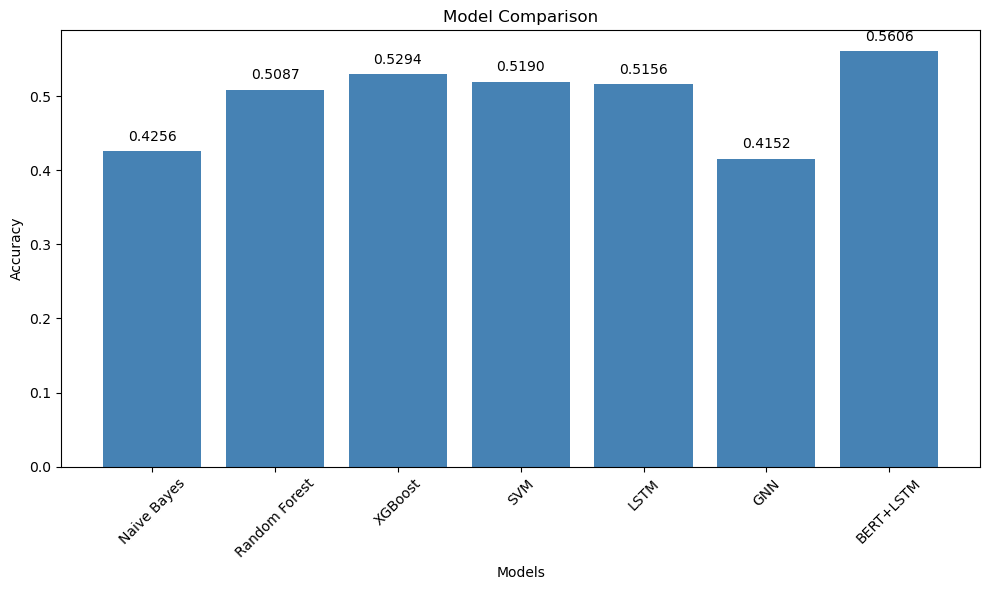


Best model: BERT+LSTM with accuracy: 0.5606
Best model saved!


In [10]:
# Function to make predictions on new poems
def predict_poem(poem_text, model_path='best_model.pkl'):
    import joblib
    
    # Load model
    if model_path.endswith('.pkl'):
        model, vectorizer, label_encoder = joblib.load(model_path)
        
        # Preprocess text
        processed_text = preprocess_text(poem_text)
        
        # Vectorize
        X = vectorizer.transform([processed_text])
        
        # Predict
        prediction = model.predict(X)[0]
        predicted_class = label_encoder.inverse_transform([prediction])[0]
        
        return predicted_class
    else:
        print("Deep learning models require a different prediction approach.")
        return None

if __name__ == "__main__":
    main()

In [1]:
!pip install graphviz

from graphviz import Digraph

# Create a Digraph object
dot = Digraph(format='png')

# Set overall styling
dot.attr(rankdir='TB', bgcolor='white')

# Add nodes for each stage
dot.node('Input', 'Poetic Text\n(Input)', shape='parallelogram', style='filled', fillcolor='lightblue', fontsize='14')

dot.node('Tokenizer', 'BERT Tokenizer\n(Tokenization)', shape='box', style='filled', fillcolor='lightgray', fontsize='14')

dot.node('BERT', 'BERT Encoder\n(Contextual Embeddings)', shape='box3d', style='filled', fillcolor='lightgoldenrodyellow', fontsize='14')

dot.node('LSTM', 'Bidirectional LSTM\n(Sequence Processing)', shape='box', style='filled', fillcolor='lightcoral', fontsize='14')

dot.node('Dropout', 'Dropout Layer\n(Regularization)', shape='ellipse', style='filled', fillcolor='lightsalmon', fontsize='14')

dot.node('FC', 'Fully Connected Layer\n(Dense Projection)', shape='box', style='filled', fillcolor='lightseagreen', fontsize='14')

dot.node('Softmax', 'Softmax Layer\n(Classification)', shape='ellipse', style='filled', fillcolor='orchid', fontsize='14')

dot.node('Output', 'Sentiment/Theme/Form\nPrediction', shape='parallelogram', style='filled', fillcolor='lightblue', fontsize='14')

# Add edges to show data flow
dot.edge('Input', 'Tokenizer', label='Tokenize')
dot.edge('Tokenizer', 'BERT', label='Word Embeddings')
dot.edge('BERT', 'LSTM', label='Contextual Features')
dot.edge('LSTM', 'Dropout', label='Processed Sequence')
dot.edge('Dropout', 'FC', label='Feature Projection')
dot.edge('FC', 'Softmax', label='Class Probabilities')
dot.edge('Softmax', 'Output', label='Final Classification')

# Save and render the diagram
dot.render('bert_lstm_architecture')



'bert_lstm_architecture.png'